In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [328]:
from imp import reload
from regain.covariance import kernel_time_graphical_lasso_; reload(kernel_time_graphical_lasso_)
from regain.datasets import kernels; reload(kernels)

n_dim = 4
n_times = 9
w_size = 3
n_samples = 30

data = kernels.make_ticc_dataset(w_size=w_size, n_dim=n_dim, n_samples=n_samples, T=n_times)
X, y = data.X, data.y

In [356]:
from sklearn.covariance import empirical_covariance
cov = []
for c in np.unique(y):
    idx = y == c
    cov.append(empirical_covariance(X[idx]))
cov = np.asarray(cov)

In [404]:
kern = []
for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[0]):
        kern.append(np.linalg.norm(linalg.pinvh(cov[i]) - linalg.pinvh(cov[j])))

In [405]:
from scipy.spatial.distance import squareform

In [406]:
kernel = squareform(kern)
mm = np.sum(np.abs(kernel), axis=1)

kernel += np.eye(cov.shape[0]) * mm

kernel /= mm

In [407]:
kernel

array([[1.        , 0.18180536, 0.14024844, 0.17668297, 0.10323592,
        0.14106792, 0.13413707, 0.18190947, 0.1282165 ],
       [0.12962613, 1.        , 0.11569429, 0.0748188 , 0.12696732,
        0.07686301, 0.11675206, 0.02782385, 0.07802017],
       [0.14418542, 0.16682047, 1.        , 0.15284839, 0.12002009,
        0.14982691, 0.14013505, 0.16569334, 0.17769094],
       [0.13335178, 0.07920069, 0.11221262, 1.        , 0.12726439,
        0.08540962, 0.09951202, 0.07157652, 0.10986586],
       [0.11767606, 0.20298472, 0.13307238, 0.19220295, 1.        ,
        0.17567014, 0.17028847, 0.20975946, 0.17632363],
       [0.09596898, 0.07333885, 0.09914462, 0.07698485, 0.10484393,
        1.        , 0.11521463, 0.08019665, 0.08542887],
       [0.15306514, 0.18685561, 0.15554317, 0.15045233, 0.17047294,
        0.19325578, 1.        , 0.18346349, 0.16656534],
       [0.13145996, 0.02820133, 0.11647158, 0.06853377, 0.13298495,
        0.08519063, 0.11618776, 1.        , 0.07788869],


In [408]:
mdl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=2, kernel=kernel).fit(X, y)

In [409]:
from regain.norm import l1_od_norm

In [410]:
mdl.similarity_matrix = kernel_time_graphical_lasso_.precision_similarity(mdl.precision_, kernel.shape[0], l1_od_norm)

In [411]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg

# needs distances
clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=2)
S = 1. / mdl.similarity_matrix - 1
labels_predict = clustering.fit_predict(S)

In [412]:
labels_pred = np.repeat(np.asarray(labels_predict), X.shape[0] / n_times)
labels_true = data.id_cluster

thetas_true = np.array([data.precs[i] for i in data.id_cluster_group])

In [413]:
print(data.id_cluster_group)
print(labels_predict)

from sklearn.metrics import v_measure_score
print(v_measure_score(data.id_cluster_group, labels_predict))

from regain.utils import structure_error, error_norm_time
print(structure_error(thetas_true, mdl.precision_, no_diagonal=True))
print(error_norm_time(thetas_true, mdl.precision_))

[0 0 0 1 1 1 0 0 0]
[0 0 0 0 0 0 1 0 0]
0.09835721382924875
{'tp': 102, 'tn': 0, 'fp': 0, 'fn': 6, 'precision': 1.0, 'recall': 0.9444444444444444, 'f1': 0.9714285714285714, 'accuracy': 0.7083333333333334, 'false_omission_rate': 1.0, 'fdr': 0.0, 'npv': 0.0, 'prevalence': 0.75, 'miss_rate': 0.05555555555555555, 'fall_out': 1, 'specificity': 0.0, 'plr': 0.9444444444444444, 'nlr': 0, 'dor': 0, 'balanced_accuracy': 0.4722222222222222, 'average_precision': 0.4939660105300628}
2.3411047820317403


In [414]:
thetas_true

array([[[ 1.87326905, -0.82459678, -0.19484875, -0.29681665],
        [-0.82459678,  1.09897128,  0.24213685,  0.68203647],
        [-0.19484875,  0.24213685,  1.50123891,  0.36737162],
        [-0.29681665,  0.68203647,  0.36737162,  1.35498495]],

       [[ 1.87326905, -0.82459678, -0.19484875, -0.29681665],
        [-0.82459678,  1.09897128,  0.24213685,  0.68203647],
        [-0.19484875,  0.24213685,  1.50123891,  0.36737162],
        [-0.29681665,  0.68203647,  0.36737162,  1.35498495]],

       [[ 1.87326905, -0.82459678, -0.19484875, -0.29681665],
        [-0.82459678,  1.09897128,  0.24213685,  0.68203647],
        [-0.19484875,  0.24213685,  1.50123891,  0.36737162],
        [-0.29681665,  0.68203647,  0.36737162,  1.35498495]],

       [[ 1.92739762, -0.67483924, -0.12536156, -0.44665924],
        [-0.67483924,  1.73190975,  0.41742392,  0.16709902],
        [-0.12536156,  0.41742392,  1.90060636,  0.02372135],
        [-0.44665924,  0.16709902,  0.02372135,  1.92867028]],



In [415]:
mdl.precision_

array([[[ 2.09887403, -0.68045338,  1.18744652, -0.20495423],
        [-0.68045338,  1.8257496 ,  0.42042274, -0.11618093],
        [ 1.18744652,  0.42042274,  3.55879889,  0.10345321],
        [-0.20495423, -0.11618093,  0.10345321,  1.89270815]],

       [[ 1.88320165, -0.02260637,  0.74261595, -0.20501848],
        [-0.02260637,  1.82176829,  0.47983212, -0.11639047],
        [ 0.74261595,  0.47983212,  2.14071672,  0.10314185],
        [-0.20501848, -0.11639047,  0.10314185,  2.02171337]],

       [[ 2.09934941,  0.57277015,  0.51136592, -0.20491675],
        [ 0.57277015,  3.20279285,  0.42039456,  0.17361343],
        [ 0.51136592,  0.42039456,  3.55876672, -0.        ],
        [-0.20491675,  0.17361343, -0.        ,  3.0909851 ]],

       [[ 1.67517592, -0.38782087,  0.77073891, -0.49955629],
        [-0.38782087,  3.55917716,  0.42043281,  0.41472187],
        [ 0.77073891,  0.42043281,  2.94615375,  0.04141118],
        [-0.49955629,  0.41472187,  0.04141118,  1.89434099]],



In [17]:
def make_datasets(n_obs=10, degree=2, clusters=3, T=15, n_samples=100, repetitions=False):
    clusters_reps = [nx.random_regular_graph(d=degree, n=n_obs) for i in range(clusters)]
    adjacencies = []
    for i in range(clusters):
        A = nx.adjacency_matrix(clusters_reps[i]).todense().astype(float)
        A[np.where(A!=0)]= np.random.rand(np.where(A!=0)[0].size)*0.45
        np.fill_diagonal(A, 1)
        adjacencies.append(A)
    
    pos = np.arange(0, T, T//(clusters+1))
    pos = np.sort(pos)
    pos = list(pos)+[T-1]
    
    thetas = []
    for i in range(len(pos)-1):
        how_many = int(pos[i+1]) - int(pos[i])-1
        new_list = [adjacencies[i%clusters]]
        target = adjacencies[(i+1)%clusters]

        for i in range(how_many):

            new = new_list[-1].copy()
            diffs = (new!=0).astype(int)-(target!=0).astype(int)
            diff = np.where(diffs!=0)
            if diff == ():
                break
            if(i==0):
                edges_per_change = int((np.nonzero(diffs)[0].shape[0]/2)//(how_many+1))
                if edges_per_change ==0:
                    edges_per_change+=1
            ixs = np.arange(diff[0].shape[0])
            np.random.shuffle(ixs)

            xs = diff[0][ixs[:edges_per_change]]
            ys = diff[1][ixs[:edges_per_change]]
            for j in range(xs.shape[0]):
                if diffs[xs[j], ys[j]] == -1:
                    new[xs[j], ys[j]] = np.random.rand(1)*0.2
                    new[ ys[j], xs[j]]=  new[xs[j], ys[j]]
                else:
                    new[xs[j], ys[j]] = 0
                    new[ ys[j], xs[j]]=0
            new_list.append(new)

        thetas += new_list
    thetas.append(target)
    covs = [np.linalg.inv(t) for t in thetas]
    samples = [np.random.multivariate_normal(np.zeros(n_obs), c, size=n_samples) for c in covs]
    return thetas, samples, covs, clusters_reps, pos

In [74]:
thetas, samples, covs, clusters_reps, pos= make_datasets(n_obs=10, degree=2, clusters=3, T=15, repetitions=False)

/Users/federicot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: covariance is not symmetric positive-semidefinite.


/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


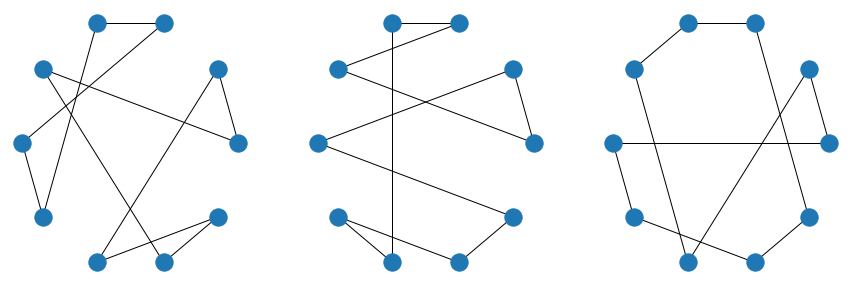

In [75]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
colors = ['red', 'blue', 'green']
for i in range(3):
    nx.draw_circular(clusters_reps[i], ax=axs[i])
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/federicot/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instea

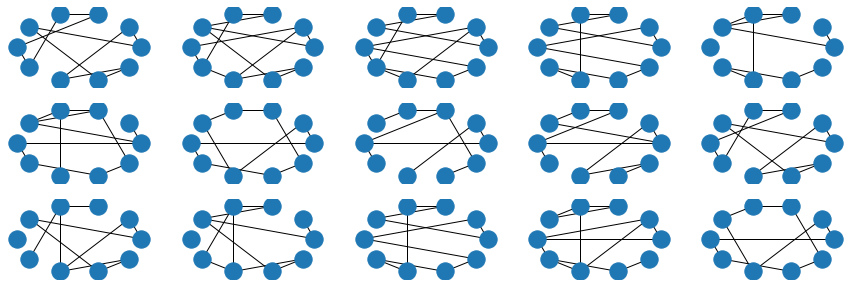

In [76]:
fig, axs = plt.subplots(3,5, figsize=(15,5))
colors = ['red', 'red', 'red', 'blue', 'blue', 'blue']
k = 0
for i in range(3):
    for j in range(5):
        g = nx.from_numpy_array(thetas[k])
        nx.draw_circular(g, ax=axs[i, j])
        k+=1
#plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

In [77]:
from regain.norm import l1_norm
distances = np.zeros((15,15))
for i, t in enumerate(thetas):
    for j, t1 in enumerate(thetas):
        distances[i,j] = l1_norm(t-t1)

distances /= np.max(distances)

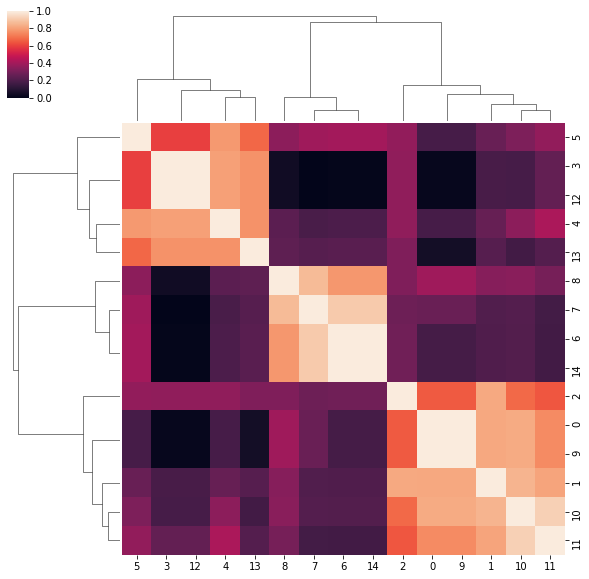

In [79]:
sns.clustermap(1-distances)

In [260]:
samples = np.array(samples)

X = np.vstack(samples)
y = np.repeat(np.arange(samples.shape[0]), samples.shape[1])

In [100]:
from importlib import reload
import regain.clustering; reload(regain.clustering)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_)
import regain.covariance.kernel_time_graphical_lasso_; reload(regain.covariance.kernel_time_graphical_lasso_)
from regain.covariance.kernel_time_graphical_lasso_ import SimilarityTimeGraphicalLasso

In [249]:
stgl = SimilarityTimeGraphicalLasso(alpha=1, beta=1, psi='l1', verbose=0, max_iter=500).fit(X, y)

In [285]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg

# needs distances
clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=3)
S = 1. / mdl.similarity_matrix - 1
labels_predict = clustering.fit_predict(S)
labels_true = clustering.fit_predict(distances)

print(labels_predict)
print(labels_true)

[1 2 0 2 0 2 2 0 2 0 2 2]
[1 1 1 0 0 0 2 2 2 1 1 1 0 0 2]


In [251]:
from sklearn.metrics import v_measure_score
v_measure_score(labels_true, labels_predict)

from regain.utils import structure_error
structure_error(np.array(thetas), stgl.precision_)